In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# --- Fichier source ---
file = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_balanced.csv"

# chunk size
chunk_size = 200_000

train_parts = []
test_parts = []

print(" Lecture par chunks...")

for chunk in pd.read_csv(file, chunksize=chunk_size):

    # Suppression de geometry si existe
    if "geometry" in chunk.columns:
        chunk = chunk.drop(columns=["geometry"])

    # Séparer X / y
    X = chunk.drop(columns=['fire'])
    y = chunk['fire']

    # Trouver colonnes catégorielles
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Encodage One-Hot
    if len(cat_cols) > 0:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Reconstituer chunk preprocessé
    processed = pd.concat([X, y], axis=1)

    # Split 70% / 30%
    mask = np.random.rand(len(processed)) < 0.7
    train_parts.append(processed[mask])
    test_parts.append(processed[~mask])

print("✔ Chunks lus et prétraités.")

# --- Concaténation finale ---
df_train = pd.concat(train_parts, ignore_index=True)
df_test = pd.concat(test_parts, ignore_index=True)

# --- Aligner les colonnes entre train et test ---
df_test = df_test.reindex(columns=df_train.columns, fill_value=0)

# Séparer X / y
X_train = df_train.drop(columns=['fire'])
y_train = df_train['fire']

X_test = df_test.drop(columns=['fire'])
y_test = df_test['fire']

print("✔ Données prêtes pour l'entraînement.")
print("Train shape :", X_train.shape)
print("Test shape :", X_test.shape)

# --- Entraîner le Decision Tree ---
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=20,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42
)

dt.fit(X_train, y_train)

# --- Prédictions ---
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

# --- Résultats ---
print("\n=== TRAINING SET REPORT ===")
print(classification_report(y_train, y_pred_train))
print("Accuracy(train):", accuracy_score(y_train, y_pred_train))

print("\n=== TEST SET REPORT ===")
print(classification_report(y_test, y_pred_test))
print("Accuracy(test):", accuracy_score(y_test, y_pred_test))

print("\nConfusion matrix (test) :")
print(confusion_matrix(y_test, y_pred_test))

print("\nDistribution training:")
print(y_train.value_counts(normalize=True))

print("\nDistribution test:")
print(y_test.value_counts(normalize=True))


 Lecture par chunks...
✔ Chunks lus et prétraités.
✔ Données prêtes pour l'entraînement.
Train shape : (72899, 42)
Test shape : (31211, 42)

=== TRAINING SET REPORT ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     58320
           1       0.95      0.93      0.94     14579

    accuracy                           0.98     72899
   macro avg       0.97      0.96      0.96     72899
weighted avg       0.98      0.98      0.98     72899

Accuracy(train): 0.9772287685702136

=== TEST SET REPORT ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     24968
           1       0.89      0.88      0.89      6243

    accuracy                           0.95     31211
   macro avg       0.93      0.93      0.93     31211
weighted avg       0.95      0.95      0.95     31211

Accuracy(test): 0.9548236198776072

Confusion matrix (test) :
[[24314   654]
 [  756  5487]]

Distribution training:

In [4]:
print("\nProfondeur de l'arbre :", dt.get_depth())
print("Nombre de feuilles :", dt.get_n_leaves())



Profondeur de l'arbre : 20
Nombre de feuilles : 1590


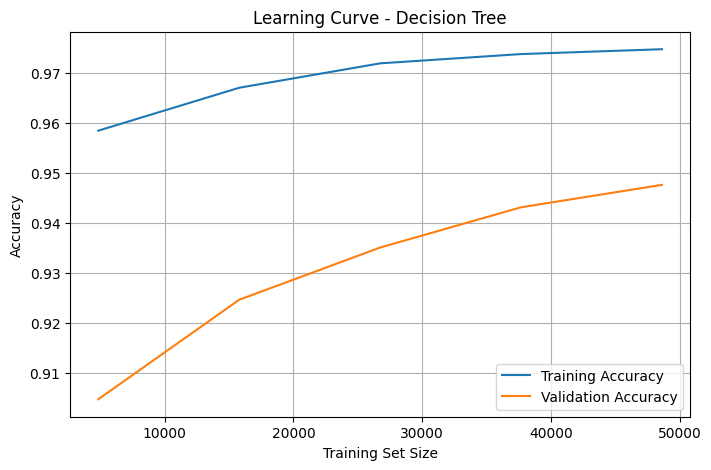

In [6]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Utiliser ton modèle : dt
train_sizes, train_scores, test_scores = learning_curve(
    dt,                      # <<< remplacer model par dt
    X_train, 
    y_train, 
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Training Accuracy")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Decision Tree")
plt.legend()
plt.grid()
plt.show()


Modèle stable
✔ Pas de surapprentissage
✔ Pas d’underfitting non plus (validation progresse bien)
✔ Très bon comportement pour un Decision Tree

In [ ]:
import numpy as np
import pandas as pd

# -------------------------------------------------------
# 1) Fonction pour calculer l'impureté (Gini)
# -------------------------------------------------------
def gini(y):
    classes = np.unique(y)
    impurity = 1.0
    for c in classes:
        p = np.sum(y == c) / len(y)
        impurity -= p ** 2
    return impurity

# -------------------------------------------------------
# 2) Trouver le meilleur split sur une seule feature
# -------------------------------------------------------
def best_split_feature(X_col, y):
    thresholds = np.unique(X_col)
    best_gini_val = 1.0
    best_thresh = None

    for t in thresholds:
        left_mask = X_col < t
        right_mask = ~left_mask

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            continue

        gini_left = gini(y[left_mask])
        gini_right = gini(y[right_mask])

        n_left = np.sum(left_mask)
        n_right = np.sum(right_mask)
        n = len(y)

        gini_split = (n_left/n)*gini_left + (n_right/n)*gini_right

        if gini_split < best_gini_val:
            best_gini_val = gini_split
            best_thresh = t

    return best_gini_val, best_thresh

# -------------------------------------------------------
# 3) Trouver le meilleur split global (toutes les features)
# -------------------------------------------------------
def best_split(X, y):
    best_feature = None
    best_threshold = None
    best_gini_value = 1.0

    for feature in range(X.shape[1]):
        gini_val, thresh = best_split_feature(X[:, feature], y)

        if thresh is not None and gini_val < best_gini_value:
            best_gini_value = gini_val
            best_threshold = thresh
            best_feature = feature

    return best_feature, best_threshold, best_gini_value

# -------------------------------------------------------
# 4) Construction récursive de l’arbre
# -------------------------------------------------------

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # valeur de prédiction si feuille

class DecisionTreeScratch:

    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    # Entrainer l'arbre
    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    # Construire l'arbre récursivement
    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Condition d'arrêt
        if (depth >= self.max_depth or
            num_labels == 1 or
            num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Trouver le meilleur split
        feature, threshold, gini_val = best_split(X, y)

        if feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Séparer les données
        left_mask = X[:, feature] < threshold
        right_mask = ~left_mask

        left = self._grow_tree(X[left_mask], y[left_mask], depth+1)
        right = self._grow_tree(X[right_mask], y[right_mask], depth+1)

        return Node(feature=feature, threshold=threshold, left=left, right=right)

    # prédiction d'un seul échantillon
    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] < node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    # prédiction globale
    def predict(self, X):
        return np.array([self._predict_one(x, self.root) for x in X])

    @staticmethod
    def _most_common_label(y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]


In [ ]:
import pandas as pd
import numpy as np

# --- Charger ton dataset ---
file =  r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_balanced.csv"
df = pd.read_csv(file)

# Retirer geometry si existe
df = df.drop(columns=["geometry"], errors="ignore")

# Séparer X, y
X = df.drop(columns=["fire"])
y = df["fire"].values

# Encodage one-hot
X = pd.get_dummies(X, drop_first=True)
X = X.values

# Split simple
n = len(X)
idx = np.random.rand(n) < 0.7

X_train = X[idx]
y_train = y[idx]
X_test = X[~idx]
y_test = y[~idx]

# --- Entraîner Decision Tree from Scratch ---
tree = DecisionTreeScratch(max_depth=5, min_samples_split=20)
tree.fit(X_train, y_train)

# Prédictions
preds = tree.predict(X_test)

# Accuracy
acc = np.mean(preds == y_test)
print("Accuracy from scratch:", acc)
